In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
%matplotlib inline

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Neural Processes for Images

This notebook contains examples of Neural Processes for images and how these can be used for various tasks like inpainting.

### Load a trained model

In [2]:
import json
from neural_process import NeuralProcessImg

# Load config file for mnist model
folder = 'model_mnist_classifier'
config_file = folder + '/config.json'
model_file = folder + '/model.pt'

with open(config_file) as f:
    config = json.load(f)

# Load trained model
model = NeuralProcessImg(config["img_size"], 
                         config["r_dim"], 
                         config["h_dim"], 
                         config["z_dim"]).to(device)
model.load_state_dict(torch.load(model_file, map_location=lambda storage, loc: storage))

<All keys matched successfully>

### Visualize some CelebA samples

In [3]:
# 这段代码是把torchvision下载的mnist训练数据转成图片的形式。
# import os
# from skimage import io
# import torchvision.datasets.mnist as mnist

# root='../mnist_data/MNIST/raw'
# train_set = (
#     mnist.read_image_file(os.path.join(root, 'train-images-idx3-ubyte')),
#     mnist.read_label_file(os.path.join(root, 'train-labels-idx1-ubyte'))
#         )
# test_set = (
#     mnist.read_image_file(os.path.join(root, 't10k-images-idx3-ubyte')),
#     mnist.read_label_file(os.path.join(root, 't10k-labels-idx1-ubyte'))
#         )
# print("training set :",train_set[0].size())
# print("test set :",test_set[0].size())

# def convert_to_img(train=True):
#     if(train):
#         f=open(root+'train.txt','w')
#         data_path=root+'/train/'
#         if(not os.path.exists(data_path)):
#             os.makedirs(data_path)
#         for i, (img,label) in enumerate(zip(train_set[0],train_set[1])):
#             img_path=data_path+str(i)+'.jpg'
#             io.imsave(img_path,img.numpy())
#             f.write(img_path+' '+str(label)+'\n')
#         f.close()
#     else:
#         f = open(root + 'test.txt', 'w')
#         data_path = root + '/test/'
#         if (not os.path.exists(data_path)):
#             os.makedirs(data_path)
#         for i, (img,label) in enumerate(zip(test_set[0],test_set[1])):
#             img_path = data_path+ str(i) + '.jpg'
#             io.imsave(img_path, img.numpy())
#             f.write(img_path + ' ' + str(label) + '\n')
#         f.close()

# convert_to_img(True)#转换训练集
# convert_to_img(False)#转换测试集

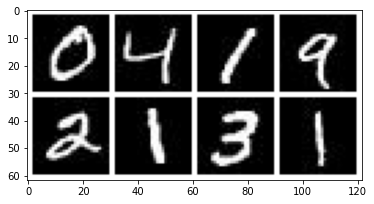

In [4]:
import imageio
from torchvision.utils import make_grid
import numpy as np

# Read images into torch.Tensor
all_imgs = torch.zeros(8, 1, 28, 28)

for i in range(8):
    img = imageio.imread('../mnist_data/MNIST/raw/train/{}.jpg'.format(i + 1))
    all_imgs[i] = torch.Tensor(img / 255.).unsqueeze(0)

# Visualize sample on a grid
img_grid = make_grid(all_imgs, nrow=4, pad_value=1.)
plt.imshow(img_grid.permute(1, 2, 0).numpy())

### Inpainting images with Neural Processes

Inpainting is the task of inferring missing pixels in a partially occluded image. Here we show examples of how Neural Processes can be used to solve this problem.

#### Occluding image

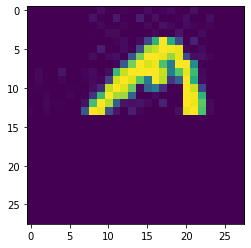

In [5]:
# Select one of the images to perform inpainting
img = all_imgs[0]

# Define a binary mask to occlude image. For Neural Processes,
# the context points will be defined as the visible pixels
context_mask = torch.zeros((28, 28)).byte()
context_mask[:14, :] = 1  # Top half of pixels are visible

# Show occluded image
occluded_img = img * context_mask.float()
plt.imshow(occluded_img.permute(1, 2, 0).numpy())

#### Generating inpaintings

/home/zmh/codes/neural-processes/utils.py:66: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:882.)
  num_points = mask[0].nonzero().size(0)
/home/zmh/codes/neural-processes/utils.py:74: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  /pytorch/aten/src/ATen/native/IndexingUtils.h:25.)
  y = img[mask_img_size].view(batch_size, num_channels, num_points)
/home/zmh/codes/neural-processes/utils.py:232: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  /pytorch/aten/src/ATen/native/IndexingUtils.h:25.)
  img_rec[context_mask_img] = img[context_mask_img]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


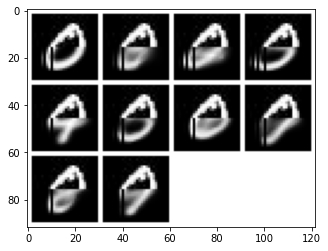

In [6]:
from utils import inpaint


num_inpaintings = 10  # Number of inpaintings to sample from model
all_inpaintings = torch.zeros(num_inpaintings, 1, 28, 28)

# Sample several inpaintings
label = torch.Tensor([0,1,2,3,4,5,6,7,8,9]).type(torch.int64)
onehot = torch.zeros(10, 10).scatter_(1, label.unsqueeze(1), 1)

for i in range(num_inpaintings):
    all_inpaintings[i] = inpaint(model, img, context_mask, onehot[i], device)

# Visualize inpainting results on a grid
inpainting_grid = make_grid(all_inpaintings, nrow=4, pad_value=1.)
plt.imshow(inpainting_grid.permute(1, 2, 0).numpy())

As can be seen, the inpaintings match the context pixels and are fairly diverse.

#### Different masks

We can use a variety of masks and image to test the model.

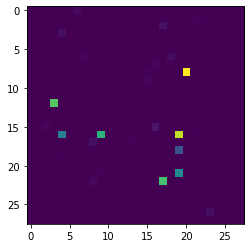

In [7]:
# Select one of the images to perform inpainting
img = all_imgs[1]

# Define a random mask
context_mask = (torch.Tensor(28, 28).uniform_() > 0.9).byte()

# Visualize occluded image
occluded_img = img * context_mask.float()
plt.imshow(occluded_img.permute(1, 2, 0).numpy())

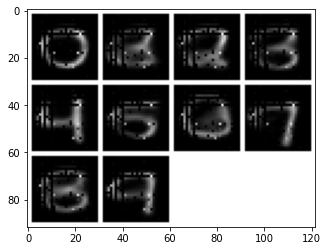

In [8]:
num_inpaintings = 10  # Number of inpaintings to sample from model
all_inpaintings = torch.zeros(num_inpaintings, 1, 28, 28)

# Sample several inpaintings
for i in range(num_inpaintings):
    all_inpaintings[i] = inpaint(model, img, context_mask, onehot[i], device)

# Visualize inpainting results on a grid
inpainting_grid = make_grid(all_inpaintings, nrow=4, pad_value=1.)
grid_as_np = inpainting_grid.permute(1, 2, 0).numpy()
# If NP returns out of range values for pixels, clip values
plt.imshow(np.clip(grid_as_np, 0, 1))